In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report
import lightgbm as lgb
import xgboost as xgb
import shap
import joblib
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


# Step 2: Data Loading and Initial Exploration


Train Dataset Head:
     Age  Gender    TB   DB  Alkphos   ALT    AST   TP  Albumin  AG_Ratio  \
0  65.0  Female   0.7  0.1    187.0  16.0   18.0  6.8      3.3      0.90   
1  62.0    Male  10.9  5.5    699.0  64.0  100.0  7.5      3.2      0.74   
2  62.0    Male   7.3  4.1    490.0  60.0   68.0  7.0      3.3      0.89   
3  58.0    Male   1.0  0.4    182.0  14.0   20.0  6.8      3.4      1.00   
4  72.0    Male   3.9  2.0    195.0  27.0   59.0  7.3      2.4      0.40   

   Disease  
0        1  
1        1  
2        1  
3        1  
4        1  

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30691 entries, 0 to 30690
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       30689 non-null  float64
 1   Gender    29789 non-null  object 
 2   TB        30043 non-null  float64
 3   DB        30130 non-null  float64
 4   Alkphos   29895 non-null  float64
 5   ALT       30153 non-null  float64
 6

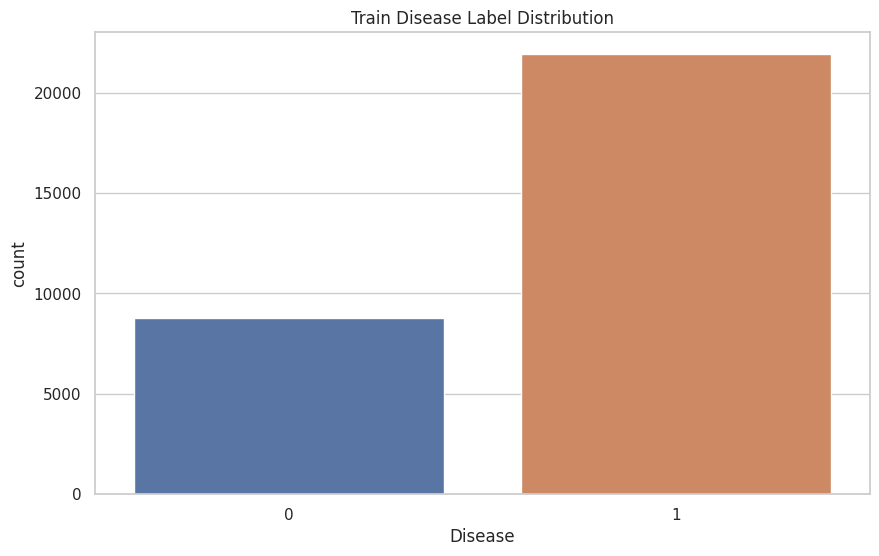

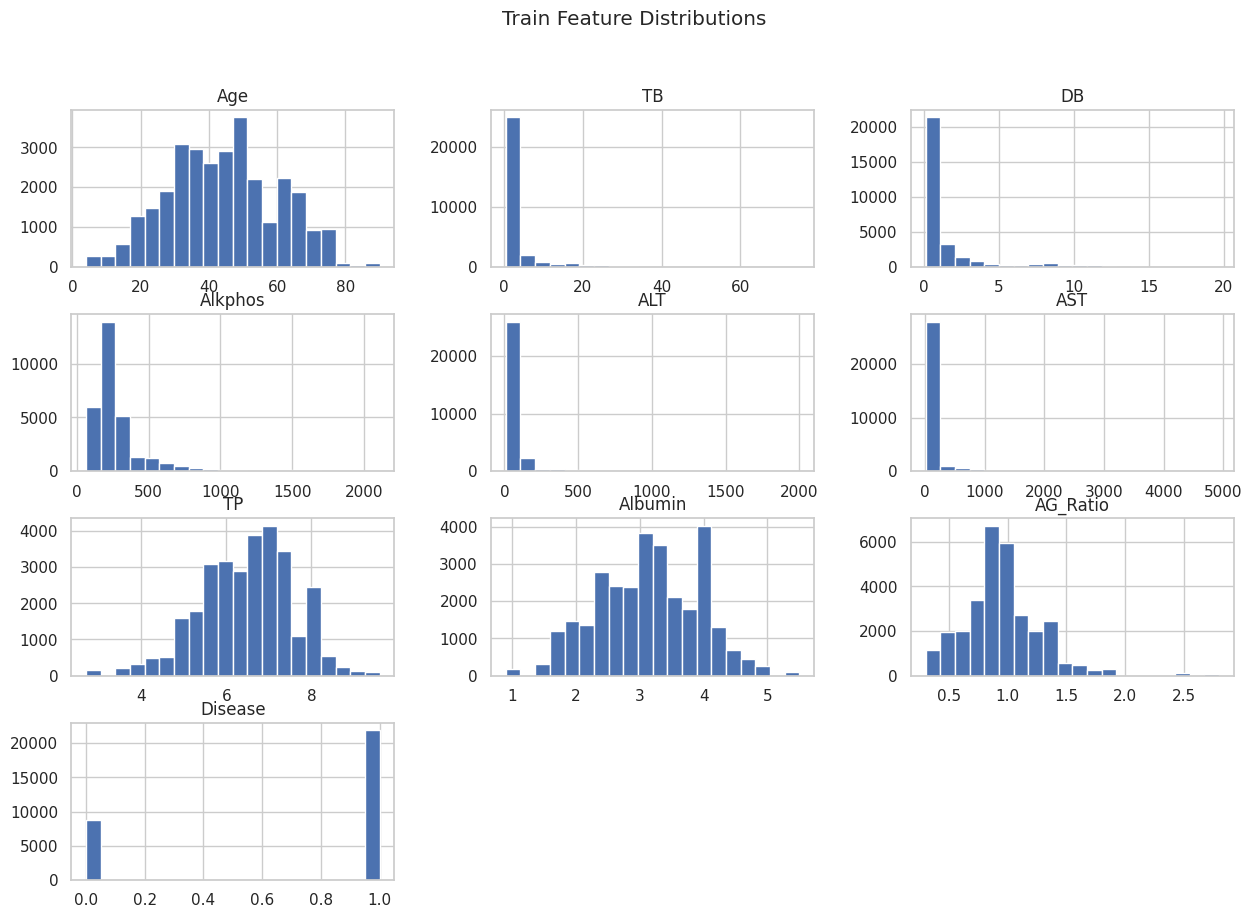

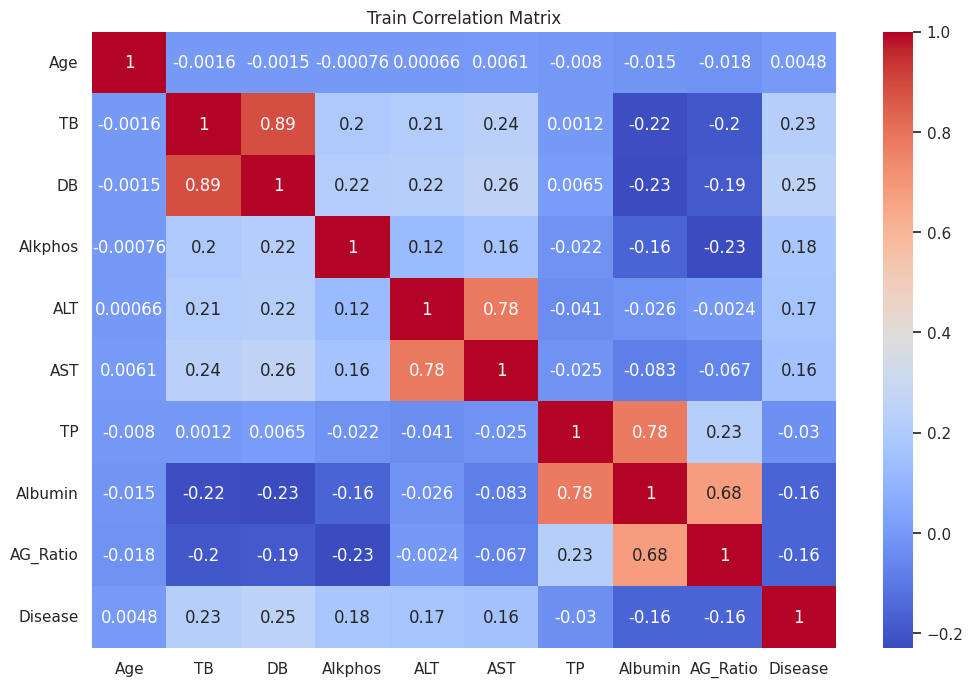


Test Dataset Head:
    Age  Gender   TB   DB  Alkphos  ALT  AST   TP  Albumin  AG_Ratio
0   66  Female  0.9  0.2      210   35   32  8.0      3.9       0.9
1   50    Male  9.4  5.2      268   21   63  6.4      2.8       0.8
2   42  Female  3.5  1.6      298   68  200  7.1      3.4       0.9
3   65    Male  1.7  0.8      315   12   38  6.3      2.1       0.5
4   22    Male  3.3  1.5      214   54  152  5.1      1.8       0.5

Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2110 entries, 0 to 2109
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       2110 non-null   int64  
 1   Gender    2110 non-null   object 
 2   TB        2110 non-null   float64
 3   DB        2110 non-null   float64
 4   Alkphos   2110 non-null   int64  
 5   ALT       2110 non-null   int64  
 6   AST       2110 non-null   int64  
 7   TP        2110 non-null   float64
 8   Albumin   2110 non-null   float64
 9   AG_Ratio  

In [11]:
# Load the train dataset
train_path = '/kaggle/input/liver-disease-patient-dataset/Liver Patient Dataset (LPD)_train.csv'
df_train = pd.read_csv(train_path, encoding='latin1')  # Use latin1 to handle encoding issues

# Load the test dataset (XLSX format, headerless)
test_path = '/kaggle/input/liver-disease-patient-dataset/test.csv.xlsx'
df_test = pd.read_excel(test_path, header=None, names=['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'ALT', 'AST', 'TP', 'Albumin', 'AG_Ratio'])

# Strip any leading/trailing spaces from column names (for train)
df_train.columns = df_train.columns.str.strip()

# Rename columns for consistency in train (after strip, keys without spaces)
column_rename = {
    'Age of the patient': 'Age',
    'Gender of the patient': 'Gender',
    'Total Bilirubin': 'TB',
    'Direct Bilirubin': 'DB',
    'Alkphos Alkaline Phosphotase': 'Alkphos',
    'Sgpt Alamine Aminotransferase': 'ALT',
    'Sgot Aspartate Aminotransferase': 'AST',
    'Total Protiens': 'TP',
    'ALB Albumin': 'Albumin',
    'A/G Ratio Albumin and Globulin Ratio': 'AG_Ratio',
    'Result': 'Disease'
}
df_train = df_train.rename(columns=column_rename)

# Map target for train only: 1 = disease (liver patient), 0 = no disease (non-liver patient)
df_train['Disease'] = df_train['Disease'].map({1: 1, 2: 0})

# Display head, info, and describe for train
print("Train Dataset Head:\n", df_train.head())
print("\nTrain Dataset Info:")
df_train.info()
print("\nTrain Dataset Description:\n", df_train.describe())

# Check for duplicates and missing values in train
print("\nTrain Duplicates:", df_train.duplicated().sum())
print("Train Missing Values:\n", df_train.isnull().sum())

# Visualizations for train: Distributions and label frequencies
plt.figure(figsize=(10, 6))
sns.countplot(x='Disease', data=df_train)
plt.title('Train Disease Label Distribution')
plt.show()

df_train.hist(bins=20, figsize=(15, 10))
plt.suptitle('Train Feature Distributions')
plt.show()

# Correlation heatmap for train (use numeric_only=True to avoid string columns)
plt.figure(figsize=(12, 8))
sns.heatmap(df_train.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Train Correlation Matrix')
plt.show()

# Brief EDA for test (no label assumed)
print("\nTest Dataset Head:\n", df_test.head())
print("\nTest Dataset Info:")
df_test.info()
print("\nTest Dataset Description:\n", df_test.describe())
print("\nTest Duplicates:", df_test.duplicated().sum())
print("Test Missing Values:\n", df_test.isnull().sum())

# Check schema consistency (train has 'Disease', test does not)
expected_columns_train = ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'ALT', 'AST', 'TP', 'Albumin', 'AG_Ratio', 'Disease']
expected_columns_test = ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'ALT', 'AST', 'TP', 'Albumin', 'AG_Ratio']
assert set(expected_columns_train) == set(df_train.columns), f"Train column mismatch! Actual: {df_train.columns.tolist()}"
assert set(expected_columns_test) == set(df_test.columns), f"Test column mismatch! Actual: {df_test.columns.tolist()}"

print("EDA completed.")

# Step 3: Data Cleaning and Preprocessing

In [13]:
# Drop duplicates
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

# Separate features and target for train (test has no target)
X_train = df_train.drop('Disease', axis=1)
y_train = df_train['Disease']
X_test = df_test.copy()  # Test has no label

# Identify numeric and categorical columns (from train)
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Impute missing values (fit on train)
num_imputer = SimpleImputer(strategy='median')
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])

# Encode categorical variables (fit on train)
encoders = {}
for col in categorical_cols:
    if X_train[col].nunique() == 2:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
        encoders[col] = le
    else:
        ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
        encoded_train = ohe.fit_transform(X_train[[col]])
        encoded_test = ohe.transform(X_test[[col]])
        encoded_cols = [f"{col}_{cat}" for cat in ohe.categories_[0][1:]]
        encoded_train_df = pd.DataFrame(encoded_train, columns=encoded_cols, index=X_train.index)
        encoded_test_df = pd.DataFrame(encoded_test, columns=encoded_cols, index=X_test.index)
        X_train = pd.concat([X_train.drop(col, axis=1), encoded_train_df], axis=1)
        X_test = pd.concat([X_test.drop(col, axis=1), encoded_test_df], axis=1)
        encoders[col] = ohe

# Assert no missing values
assert X_train.isnull().sum().sum() == 0, "Missing values in train!"
assert X_test.isnull().sum().sum() == 0, "Missing values in test!"

print("Preprocessing completed. Train Features:\n", X_train.head())
print("Test Features:\n", X_test.head())

Preprocessing completed. Train Features:
     Age  Gender    TB   DB  Alkphos   ALT    AST   TP  Albumin  AG_Ratio
0  65.0       0   0.7  0.1    187.0  16.0   18.0  6.8      3.3      0.90
1  62.0       1  10.9  5.5    699.0  64.0  100.0  7.5      3.2      0.74
2  62.0       1   7.3  4.1    490.0  60.0   68.0  7.0      3.3      0.89
3  58.0       1   1.0  0.4    182.0  14.0   20.0  6.8      3.4      1.00
4  72.0       1   3.9  2.0    195.0  27.0   59.0  7.3      2.4      0.40
Test Features:
     Age  Gender   TB   DB  Alkphos   ALT    AST   TP  Albumin  AG_Ratio
0  66.0       0  0.9  0.2    210.0  35.0   32.0  8.0      3.9       0.9
1  50.0       1  9.4  5.2    268.0  21.0   63.0  6.4      2.8       0.8
2  42.0       0  3.5  1.6    298.0  68.0  200.0  7.1      3.4       0.9
3  65.0       1  1.7  0.8    315.0  12.0   38.0  6.3      2.1       0.5
4  22.0       1  3.3  1.5    214.0  54.0  152.0  5.1      1.8       0.5


# Step 4: Feature Engineering

In [14]:
# Create binary clinical flags on original (imputed) values
X_train['AST_high'] = (X_train['AST'] > 40).astype(int)
X_train['ALT_high'] = (X_train['ALT'] > 40).astype(int)
X_train['Albumin_low'] = (X_train['Albumin'] < 3.5).astype(int)

X_test['AST_high'] = (X_test['AST'] > 40).astype(int)
X_test['ALT_high'] = (X_test['ALT'] > 40).astype(int)
X_test['Albumin_low'] = (X_test['Albumin'] < 3.5).astype(int)

# Log-transform skewed features (check on train original)
skewed_cols = [col for col in numeric_cols if df_train[col].skew() > 1]
for col in skewed_cols:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])

# Scale numeric features (fit on train, transform both)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Check for multicollinearity on train
corr_matrix = X_train.corr()
print("Train Correlation Matrix:\n", corr_matrix)

# Drop highly correlated features if > 0.8 (example; customize based on output)
high_corr_threshold = 0.8
corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = corr_pairs[(corr_pairs > high_corr_threshold) & (corr_pairs < 1)]
if not high_corr_pairs.empty:
    print("High correlations in train:", high_corr_pairs)
    # Example: Drop 'DB' if highly correlated with 'TB' (common in liver data)
    drop_cols = ['DB']  # Adjust based on actual high correlations
    if all(col in X_train.columns for col in drop_cols):
        X_train = X_train.drop(drop_cols, axis=1)
        X_test = X_test.drop(drop_cols, axis=1)

# Document features
feature_metadata = {
    'features': list(X_train.columns),
    'clinical_flags': ['AST_high', 'ALT_high', 'Albumin_low'],
    'transformations': skewed_cols
}
with open('feature_metadata.json', 'w') as f:
    json.dump(feature_metadata, f)

print("Feature Engineering completed. Train Features:\n", X_train.head())
print("Test Features:\n", X_test.head())

Train Correlation Matrix:
                   Age    Gender        TB        DB   Alkphos       ALT  \
Age          1.000000  0.021026 -0.002818 -0.004020  0.002719  0.001128   
Gender       0.021026  1.000000  0.007357  0.008016 -0.001277  0.013653   
TB          -0.002818  0.007357  1.000000  0.955784  0.327903  0.415134   
DB          -0.004020  0.008016  0.955784  1.000000  0.325492  0.406012   
Alkphos      0.002719 -0.001277  0.327903  0.325492  1.000000  0.327768   
ALT          0.001128  0.013653  0.415134  0.406012  0.327768  1.000000   
AST          0.002629  0.008857  0.513188  0.508910  0.301048  0.812756   
TP          -0.009365  0.007731 -0.037690 -0.031319  0.005218 -0.005099   
Albumin     -0.010387  0.009098 -0.279145 -0.273334 -0.163864 -0.036925   
AG_Ratio    -0.008645  0.006955 -0.293606 -0.287429 -0.283439 -0.063851   
AST_high    -0.001158  0.011913  0.411902  0.416879  0.309333  0.567137   
ALT_high    -0.004014  0.009801  0.368928  0.361762  0.329854  0.750651  

# Step 5: Cross-Validation Setup

In [15]:
# Cross-validation setup for train
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (19368, 12) Test shape: (1973, 12)


# Step 6: Baseline Model - Logistic Regression

In [17]:
# Logistic Regression
lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

# Predictions on test (no metrics since no labels)
y_pred_lr = lr.predict(X_test)
y_pred_proba_lr = lr.predict_proba(X_test)[:, 1]

print("Baseline predictions on test generated.")

Baseline predictions on test generated.


# Step 7: Advanced Models

In [18]:
# RandomForest
rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 10]}
rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=skf, scoring='roc_auc', n_iter=5)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

# LightGBM
lgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
lgb_search = RandomizedSearchCV(lgb.LGBMClassifier(random_state=42, verbose=-1), lgb_params, cv=skf, scoring='roc_auc', n_iter=5)
lgb_search.fit(X_train, y_train)
lgb_best = lgb_search.best_estimator_

# XGBoost
xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
xgb_search = RandomizedSearchCV(xgb.XGBClassifier(random_state=42, eval_metric='logloss'), xgb_params, cv=skf, scoring='roc_auc', n_iter=5)
xgb_search.fit(X_train, y_train)
xgb_best = xgb_search.best_estimator_

# Predict on test (example with XGBoost)
y_pred_xgb = xgb_best.predict(X_test)
y_pred_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]
print("XGBoost predictions on test generated.")

XGBoost predictions on test generated.


# Step 8: Ensemble/Stacking

In [19]:
# Stacking Classifier
estimators = [('rf', rf_best), ('lgb', lgb_best), ('xgb', xgb_best)]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=skf)
stack.fit(X_train, y_train)

# Predict on test
y_pred_stack = stack.predict(X_test)
y_pred_proba_stack = stack.predict_proba(X_test)[:, 1]
print("Stacking predictions on test generated.")

Stacking predictions on test generated.


# Step 9: Metrics and Evaluation

In [20]:
# Function to compute CV metrics on train
def evaluate_model_cv(model, X, y, skf):
    roc_aucs, pr_aucs = [], []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_tr, y_tr)
        y_proba = model.predict_proba(X_val)[:, 1]
        roc_aucs.append(roc_auc_score(y_val, y_proba))
        prec, rec, _ = precision_recall_curve(y_val, y_proba)
        pr_aucs.append(auc(rec, prec))
    return np.mean(roc_aucs), np.std(roc_aucs), np.mean(pr_aucs), np.std(pr_aucs)

# CV on train for stacking
mean_roc, std_roc, mean_pr, std_pr = evaluate_model_cv(stack, X_train, y_train, skf)
print(f"CV ROC AUC on Train: {mean_roc} ± {std_roc}")
print(f"CV PR AUC on Train: {mean_pr} ± {std_pr}")

# Save test predictions (e.g., for submission)
test_predictions = pd.DataFrame({
    'Prediction': y_pred_stack,
    'Probability_Disease': y_pred_proba_stack
})
test_predictions.to_csv('test_predictions.csv', index=False)
print("Test predictions saved to 'test_predictions.csv'.")

CV ROC AUC on Train: 0.9994789589107063 ± 0.0003332366309105869
CV PR AUC on Train: 0.9996300352005107 ± 0.0002993277851620193
Test predictions saved to 'test_predictions.csv'.


# Step 10: Explainability with SHAP

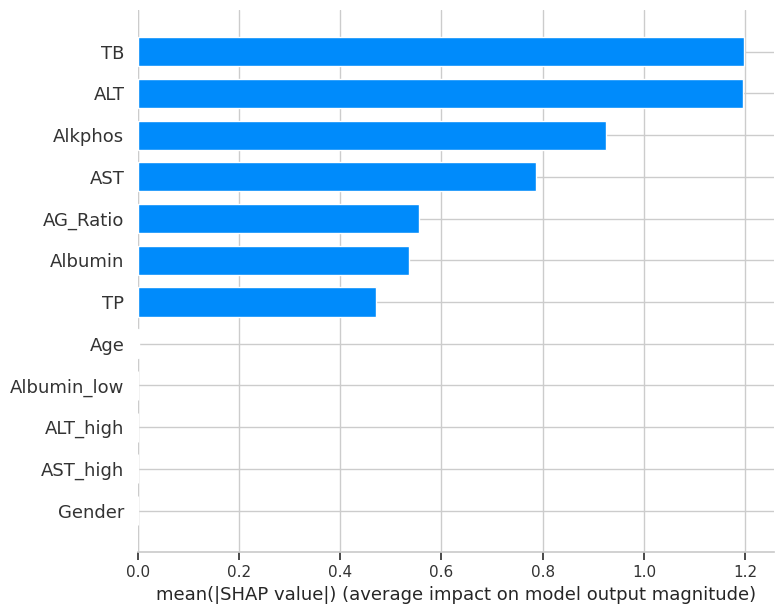

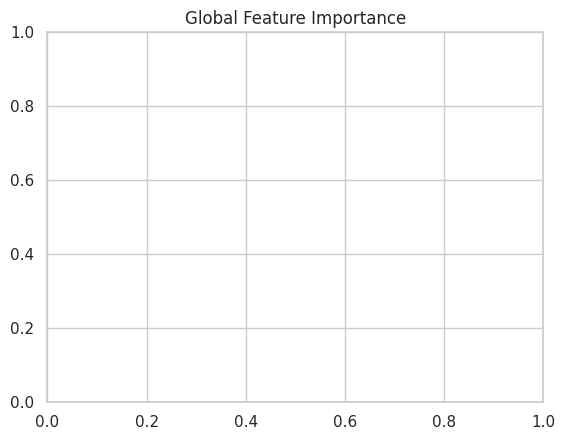

In [21]:
# SHAP for tree-based model (e.g., XGBoost)
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.title('Global Feature Importance')
plt.show()

# Example patient-level explanation (first test sample)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

# Step 11: Pipeline Persistence and Metadata

In [23]:
# Save model and preprocessors
joblib.dump(stack, 'liver_disease_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(num_imputer, 'num_imputer.pkl')
joblib.dump(cat_imputer, 'cat_imputer.pkl')
joblib.dump(encoders, 'encoders.pkl')

# Function to make hyperparameters JSON-serializable (convert non-serializable objects like StratifiedKFold to strings)
def make_serializable(d):
    for k, v in list(d.items()):
        if isinstance(v, dict):
            d[k] = make_serializable(v)
        elif not isinstance(v, (int, float, str, bool, type(None))):
            d[k] = str(v)
    return d

# Save metadata
metadata = {
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'train_source': train_path,
    'test_source': test_path,
    'features': list(X_train.columns),
    'hyperparameters': make_serializable(stack.get_params()),
    'performance': {
        'cv_roc_mean': mean_roc,
        'cv_roc_std': std_roc
    }
}
with open('pipeline_metadata.json', 'w') as f:
    json.dump(metadata, f)

print("Pipeline saved successfully.")

Pipeline saved successfully.
